In [51]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # Functions to easily make maps and plots

# Make a fresh start
import argopy
argopy.set_options(cachedir='cache_bgc')
argopy.reset_options()
argopy.clear_cache()

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import gsw
import pandas as pd
xr.set_options(display_expand_attrs = False)

In [3]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
Loaded: True (320712 records)
Searched: False

In [6]:
# Select one random WMO:
WMO_list = idx.read_wmo(index=True)
WMO = WMO_list[np.random.randint(len(WMO_list))]

# Or impose your float:
WMO = 5904105

print('We will work with float: %i' % WMO)
# Search for all profiles from this float:
idx.search_wmo(WMO)

We will work with float: 5904105


<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
Loaded: True (320712 records)
Searched: True (183 matches, 0.0571%)

In [7]:
# Get the list of parameters for this float:
idx.read_params()

['BBP700', 'CHLA', 'DOXY', 'NITRATE', 'PRES', 'PSAL', 'TEMP']

In [75]:
# Get the list of BGC parameters:
bgc_params = idx.read_params()
[bgc_params.remove(p) for p in ['PRES', 'TEMP', 'PSAL']]  # Remove core variables from the list
bgc_params = ['BBP700','SPICINESS','AOU']


In [76]:
f = DataFetcher(ds='bgc', mode='expert', params='all').profile(WMO, np.arange(0, 200)).load()

In [25]:
f

<datafetcher.erddap>
Name: Ifremer erddap Argo BGC data fetcher for profiles
API: https://erddap.ifremer.fr/erddap
Domain: WMO5904105_CYC0_CYC1_CYC2_CYC3 ... 95_CYC196_CYC197_CYC198_CYC199
BGC variables: ['BBP700', 'CHLA', 'DOXY', 'NITRATE', 'PRES', 'PSAL', 'TEMP']
BGC 'must be measured' variables: []
Performances: cache=False, parallel=False
User mode: expert
Dataset: bgc

In [11]:
ds = f.data

In [3]:
def calculate_spiciness_for_all_profiles(ds):
    spiciness = []

    for n_prof in range(ds.dims['N_POINTS']):
        lat = ds.LATITUDE[n_prof].data
        lon = ds.LONGITUDE[n_prof].data
        temp_a = ds.TEMP_ADJUSTED[n_prof].data
        psal_a = ds.PSAL_ADJUSTED[n_prof].data
        pres_a = ds.PRES_ADJUSTED[n_prof].data

        SA_a = gsw.SA_from_SP(SP=psal_a, p=pres_a, lon=lon, lat=lat)  # g/kg
        CT_a = gsw.CT_from_t(SA=SA_a, t=temp_a, p=pres_a)  # °C
        SPI_a = gsw.spiciness0(SA=SA_a, CT=CT_a)  # Spiciness

        spiciness.append(SPI_a)

    # Convert the spiciness list to an xarray.DataArray and add it to the dataset
    spiciness_da = xr.DataArray(spiciness, dims=['N_POINTS'], coords={'N_POINTS': ds.N_POINTS})
    ds['SPICINESS'] = spiciness_da

    return ds


In [67]:
ds = calculate_spiciness_for_all_profiles(ds)


In [2]:
def calculate_AOU_for_all_profiles(ds):
    aou_list = []
    doxy_list = []

    for n_prof in range(ds.dims['N_POINTS']):
        lat = ds.LATITUDE[n_prof].data
        lon = ds.LONGITUDE[n_prof].data
        temp_a = ds.TEMP_ADJUSTED[n_prof].data
        psal_a = ds.PSAL_ADJUSTED[n_prof].data
        pres_a = ds.PRES_ADJUSTED[n_prof].data

        # Compute Absolute Salinity and Conservative Temperature
        SA_a = gsw.SA_from_SP(SP=psal_a, p=pres_a, lon=lon, lat=lat)  # g/kg
        CT_a = gsw.CT_from_t(SA=SA_a, t=temp_a, p=pres_a)  # °C

        # Calculate Oxygen Solubility
        O2sol_a = gsw.O2sol(SA=SA_a, CT=CT_a, p=pres_a, lon=lon, lat=lat)  # umol/kg

        # Extract the adjusted dissolved oxygen
        doxy_a = ds.DOXY_ADJUSTED[n_prof].data  # umol/kg

        # Calculate AOU
        AOU_a = O2sol_a - doxy_a  # umol/kg

        # Append the results to the lists
        aou_list.append(AOU_a)
        doxy_list.append(doxy_a)

    # Convert the lists to xarray.DataArray and add them to the dataset
    aou_da = xr.DataArray(aou_list, dims=['N_POINTS'], coords={'N_POINTS': ds.N_POINTS})
    doxy_da = xr.DataArray(doxy_list, dims=['N_POINTS'], coords={'N_POINTS': ds.N_POINTS})

    ds['AOU'] = aou_da
    ds['DOXY'] = doxy_da

    return ds

ds = calculate_AOU_for_all_profiles(ds)

NameError: name 'ds' is not defined

In [73]:
ds

<xarray.Dataset>
Dimensions:                 (N_POINTS: 98871)
Coordinates:
    LATITUDE                (N_POINTS) float64 ...
    LONGITUDE               (N_POINTS) float64 ...
    TIME                    (N_POINTS) datetime64[ns] 2013-03-03T07:07:55 ......
  * N_POINTS                (N_POINTS) int64 0 1 2 3 ... 98867 98868 98869 98870
Data variables: (12/50)
    BBP700                  (N_POINTS) float32 ...
    BBP700_ADJUSTED         (N_POINTS) float32 ...
    BBP700_ADJUSTED_ERROR   (N_POINTS) float32 ...
    BBP700_ADJUSTED_QC      (N_POINTS) int64 0 0 1 0 0 0 1 0 ... 1 1 1 1 1 1 1 1
    BBP700_DATA_MODE        (N_POINTS) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    BBP700_QC               (N_POINTS) int64 0 0 2 0 0 0 2 0 ... 2 2 2 2 2 2 2 2
    ...                      ...
    TEMP_ADJUSTED_QC        (N_POINTS) int64 1 1 8 1 1 1 8 1 ... 1 1 1 1 1 1 1 1
    TEMP_DATA_MODE          (N_POINTS) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    TEMP_QC                 (N_POINTS) int64 1 1 8 1 1 1 8 1 ... 1 1 1 1 1 1 1 1
    TIME_QC                 (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    SPICINESS               (N_POINTS) float64 -1.816 -1.816 ... -0.05888
    AOU                     (N_POINTS) float64 nan nan 17.61 ... 149.6 149.0
Attributes: (7)

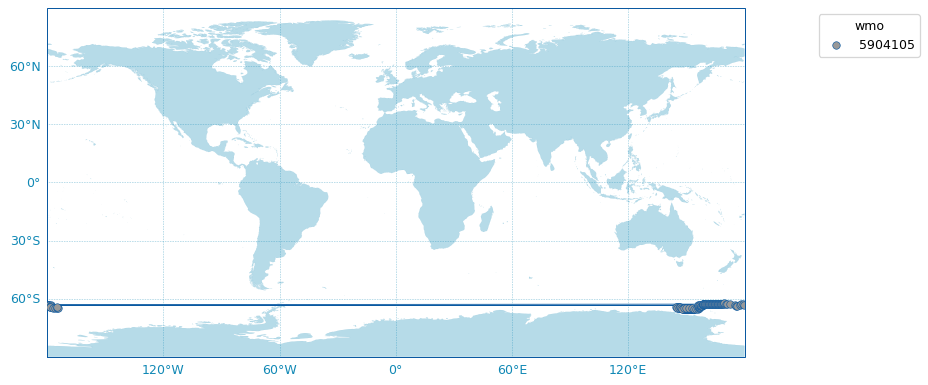

In [23]:
# But here, we use the index retrieved with the DataFetcher:
scatter_map(f.index, set_global=True);

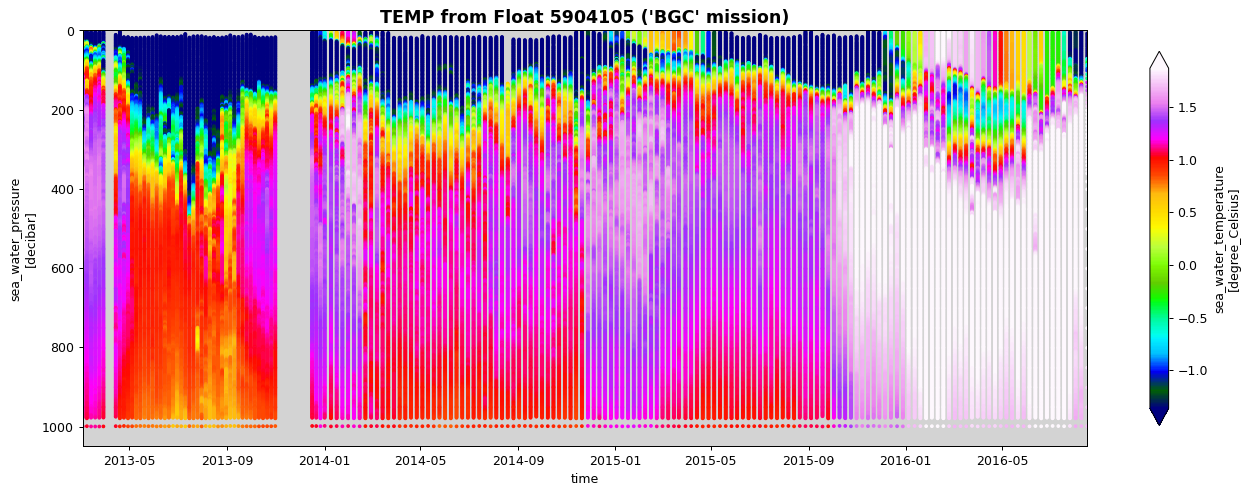

In [24]:
fig, ax = scatter_plot(ds, 'TEMP')
ax.set_title("%s from Float %i ('%s' mission)" % ('TEMP', WMO, f.mission), fontdict={'weight': 'bold', 'size': 14});

In [77]:
dsp = ds.argo.point2profile()
# std_lev = np.arange(0, np.round(ds['PRES'].max())-200, 25.0)
std_lev = np.arange(0., 1000., 10.0)
dsi = dsp.argo.interp_std_levels(std_lev)
dsi

<xarray.Dataset>
Dimensions:                (N_PROF: 183, PRES_INTERPOLATED: 100)
Coordinates:
  * N_PROF                 (N_PROF) int64 0 1 2 3 4 5 ... 178 179 180 181 182
    LATITUDE               (N_PROF) float64 -65.0 -64.81 ... -64.78 -64.38
    LONGITUDE              (N_PROF) float64 150.1 150.9 151.8 ... -174.4 -174.7
    TIME                   (N_PROF) datetime64[ns] 2013-03-03T07:07:55 ... 20...
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) float64 0.0 10.0 ... 980.0 990.0
Data variables: (12/27)
    AOU                    (N_PROF, PRES_INTERPOLATED) float64 17.61 ... 149.1
    BBP700                 (N_PROF, PRES_INTERPOLATED) float32 0.0005851 ... ...
    BBP700_ADJUSTED        (N_PROF, PRES_INTERPOLATED) float32 0.0005851 ... ...
    BBP700_DATA_MODE       (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    CHLA                   (N_PROF, PRES_INTERPOLATED) float32 0.2448 ... 0.0432
    CHLA_ADJUSTED          (N_PROF, PRES_INTERPOLATED) float32 0.126 ... 0.0036
    ...                     ...
    PSAL_ADJUSTED          (N_PROF, PRES_INTERPOLATED) float32 32.49 ... 34.74
    PSAL_DATA_MODE         (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    SPICINESS              (N_PROF, PRES_INTERPOLATED) float64 -1.816 ... -0....
    TEMP                   (N_PROF, PRES_INTERPOLATED) float32 -1.601 ... 1.712
    TEMP_ADJUSTED          (N_PROF, PRES_INTERPOLATED) float32 -1.601 ... 1.712
    TEMP_DATA_MODE         (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
Attributes: (8)

In [78]:
# Define usefull functions

# Try to define readible color bounds for each BGC variables 
# (this is probably NOT appropriate for all floats !)
c_bounds = {'BBP700': (2e-5, 70e-5),
            'CDOM': (0, 2.5),
            'CHLA': (0, 0.2),
            'DOWNWELLING_PAR': (0, 600),
            'DOWN_IRRADIANCE380': (0, 1),
            'DOWN_IRRADIANCE412': (0, 1),
            'DOWN_IRRADIANCE490': (0, 1),
            'DOXY': (50,400),
            'SPICINESS': (-1, 1),
           }

In [79]:
# Cycle 20 : 2013-06-09 
# Cycle 23 : "2013-06-24"  
# Cycle 57 : "2013-12-16"
# Cycle 83 : "2014-06-15"
# Cycle 99 : "2014-10-08"
# Cycle 108 : "2014-12-12"
# Cycle 142 : "2015-08-13"

# Define the events with corresponding pressure levels and dates
subduction_events = [
    {'date': "2013-06-09", 'pressure': 340},
    {'date': "2013-06-24", 'pressure': 300},
    {'date': "2014-10-08", 'pressure': 220},
    # Add more events as needed
]



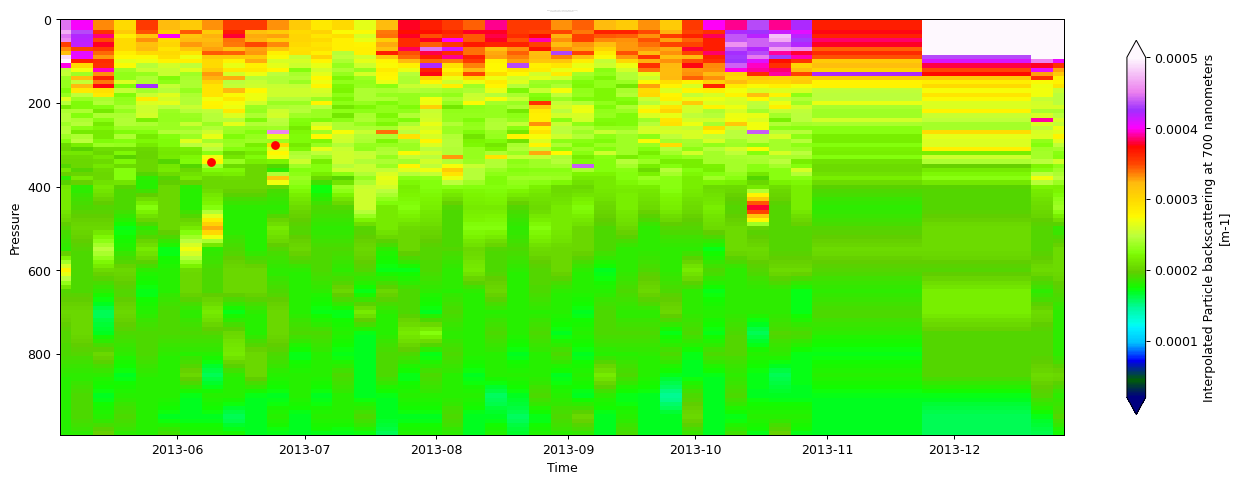

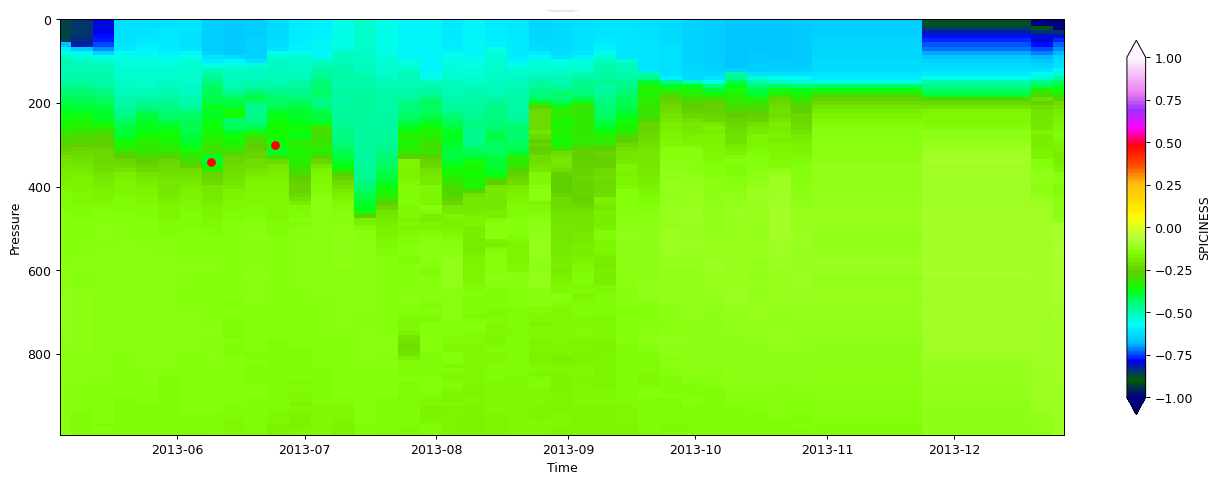

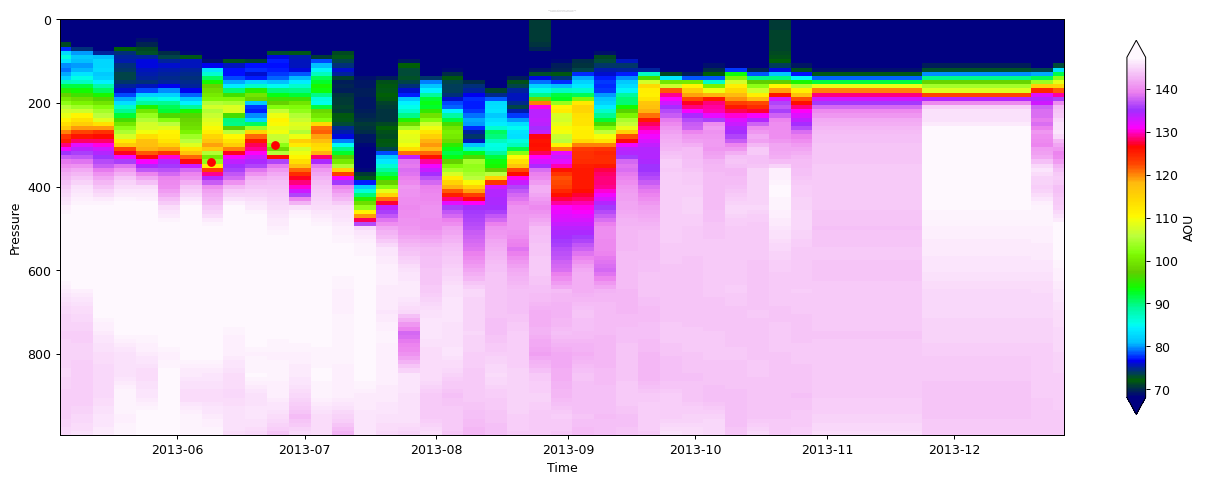

In [85]:
subset_dsi = dsi.where((dsi.TIME >= np.datetime64("2013-05-01")) & (dsi.TIME < np.datetime64("2014-01-01")), drop=True)


# Define readable color bounds for each BGC variable
c_bounds = {
    'BBP700': (2e-5, 50e-5),
    'CDOM': (0, 2.5),
    'CHLA': (0, 0.2),
    'DOWNWELLING_PAR': (0, 600),
    'DOWN_IRRADIANCE380': (0, 1),
    'DOWN_IRRADIANCE412': (0, 1),
    'DOWN_IRRADIANCE490': (0, 1),
    'DOXY': (50, 400),
    'SPICINESS': (-1, 1),
}


# Plot all variables
for param in bgc_params:
    vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)
    
    fig, ax = scatter_plot(subset_dsi, param, this_y='PRES_INTERPOLATED', vmin=vmin, vmax=vmax)
    ax.set_title(f"{param} from Float {WMO} ('{f.mission}' mission)\nSamples interpolated in pressure", 
                 fontdict={'weight': 'bold', 'size': 0.2,'alpha':0.2})

    # Add markers for subduction events
    for event in subduction_events:
        event_time = pd.to_datetime(event['date'])
        ax.plot(event_time, event['pressure'], 'ro')  # 'ro' creates a red circle marker

    # Additional plot customizations
    ax.set_xlabel("Time")
    ax.set_ylabel("Pressure")

plt.show()


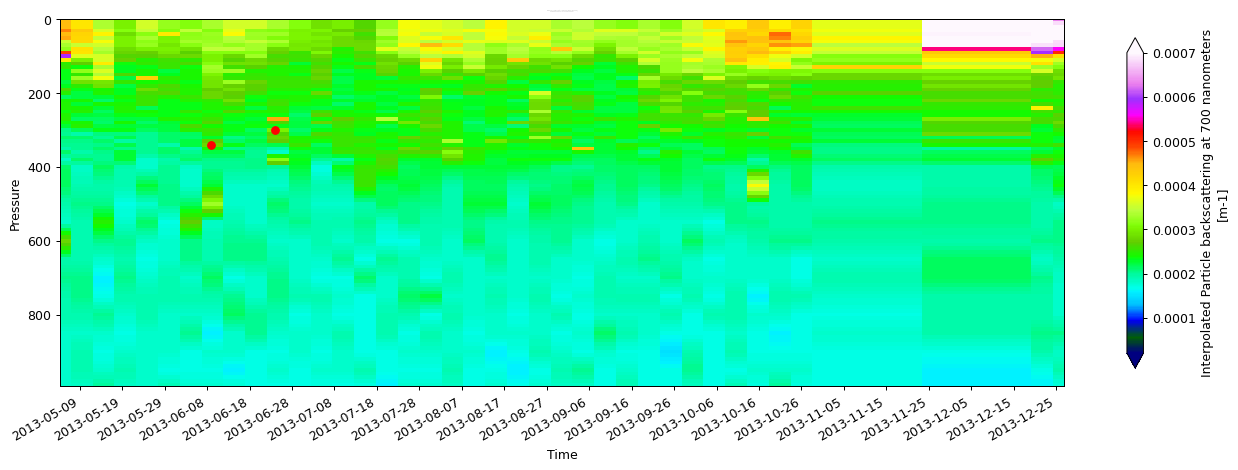

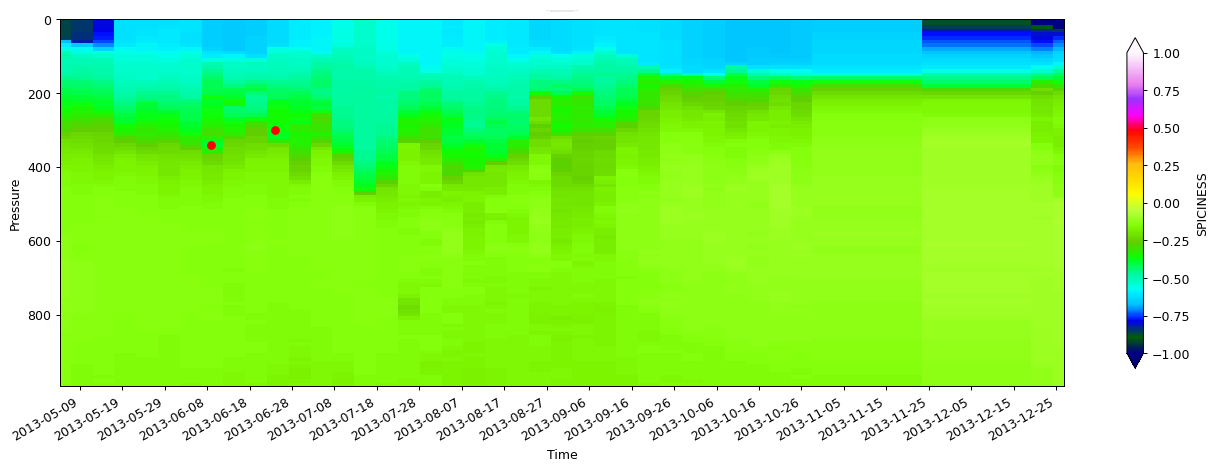

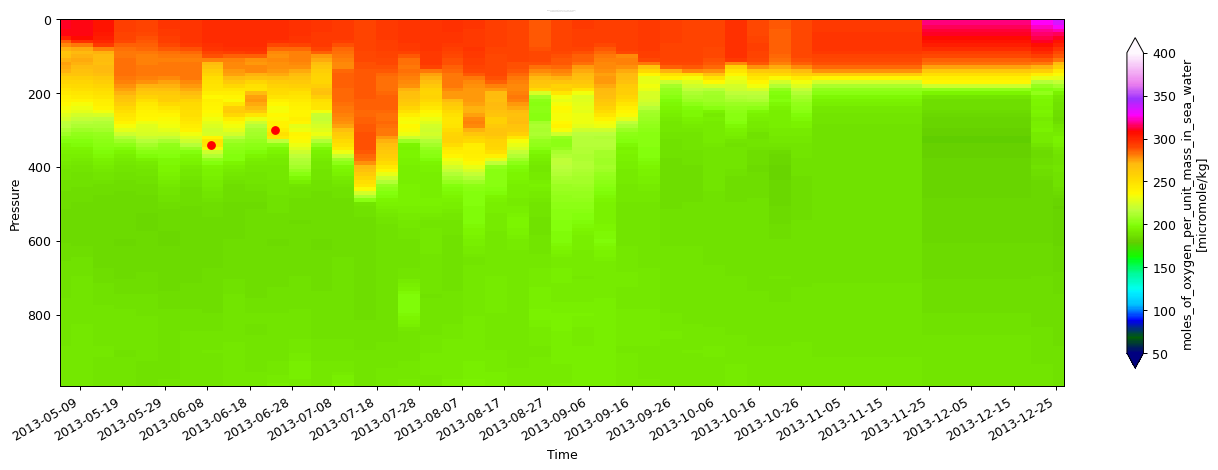

In [72]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define readable color bounds for each BGC variable
c_bounds = {
    'BBP700': (2e-5, 70e-5),
    'CDOM': (0, 2.5),
    'CHLA': (0, 0.2),
    'DOWNWELLING_PAR': (0, 600),
    'DOWN_IRRADIANCE380': (0, 1),
    'DOWN_IRRADIANCE412': (0, 1),
    'DOWN_IRRADIANCE490': (0, 1),
    'DOXY': (50, 400),
    'SPICINESS': (-1, 1),
    'AOU':(0,200)
}

# Plot all variables
for param in bgc_params:
    vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)
    
    fig, ax = scatter_plot(subset_dsi, param, this_y='PRES_INTERPOLATED', vmin=vmin, vmax=vmax)
    ax.set_title(f"{param} from Float {WMO} ('{f.mission}' mission)\nSamples interpolated in pressure", 
                 fontdict={'weight': 'bold', 'size': 0.2, 'alpha': 0.2})

    # Set x-axis to show daily ticks
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Set interval to 5 days, adjust as needed
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format to show year-month-day

    # Rotate date labels for better readability
    fig.autofmt_xdate()

    # Add markers for subduction events
    for event in subduction_events:
        event_time = pd.to_datetime(event['date'])
        ax.plot(event_time, event['pressure'], 'ro')  # 'ro' creates a red circle marker

    # Additional plot customizations
    ax.set_xlabel("Time")
    ax.set_ylabel("Pressure")

plt.show()


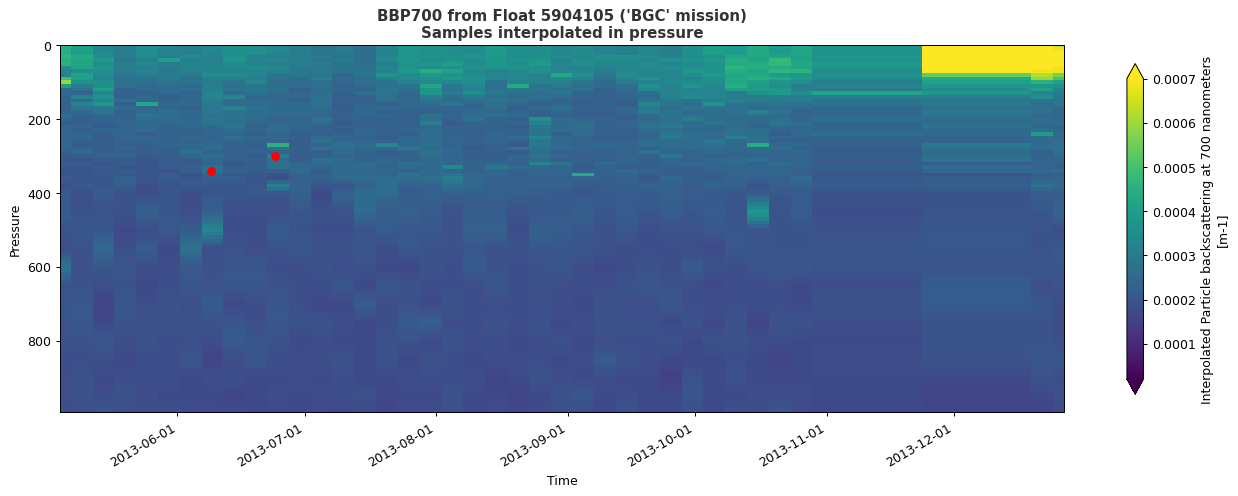

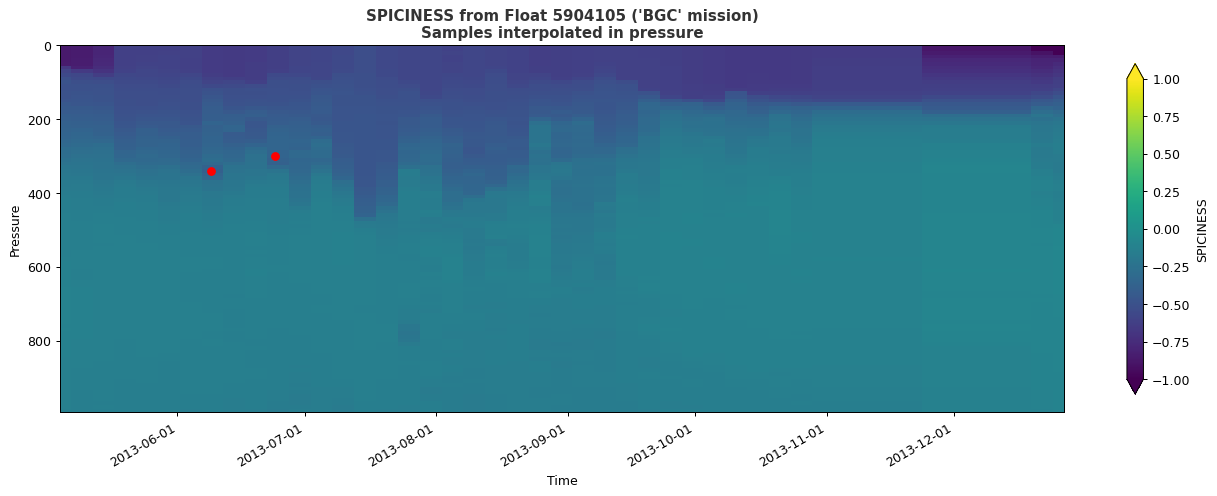

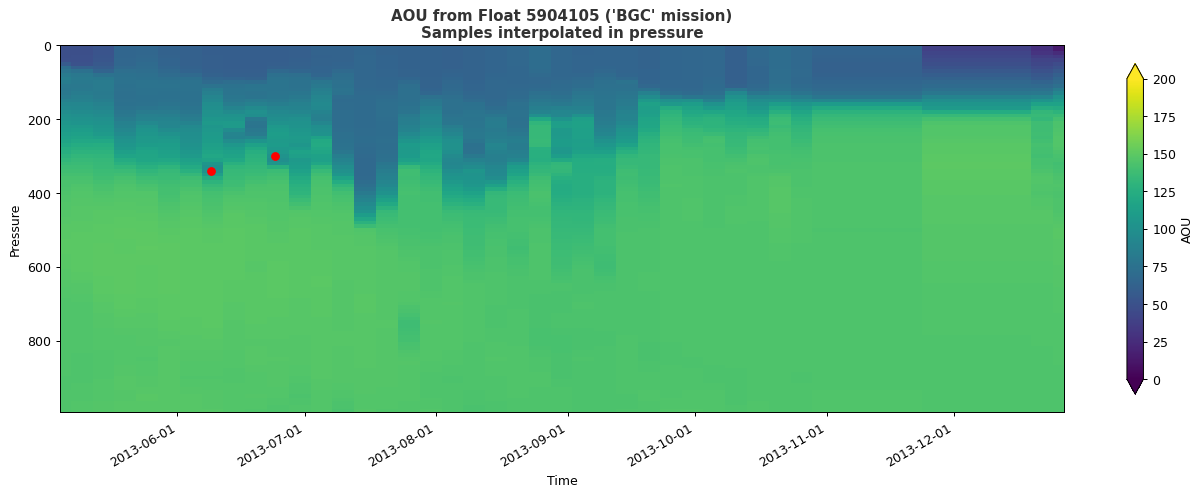

In [86]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Choose a colormap for the gradient
cmap = plt.get_cmap('viridis')  # You can use other colormaps like 'plasma', 'coolwarm', etc.
# Define readable color bounds for each BGC variable

c_bounds = {
    'BBP700': (2e-5, 70e-5),
    'CDOM': (0, 2.5),
    'CHLA': (0, 0.2),
    'DOWNWELLING_PAR': (0, 600),
    'DOWN_IRRADIANCE380': (0, 1),
    'DOWN_IRRADIANCE412': (0, 1),
    'DOWN_IRRADIANCE490': (0, 1),
    'DOXY': (50, 400),
    'SPICINESS': (-1, 1),
    'AOU':(0,200)
}


for param in bgc_params:
    vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)
    
    fig, ax = scatter_plot(subset_dsi, param, this_y='PRES_INTERPOLATED', vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(f"{param} from Float {WMO} ('{f.mission}' mission)\nSamples interpolated in pressure", 
                 fontdict={'weight': 'bold', 'size': 12,'alpha':0.8})

    # Add markers for subduction events
    for event in subduction_events:
        event_time = pd.to_datetime(event['date'])
        ax.plot(event_time, event['pressure'], 'ro')  # 'ro' creates a red circle marker

    # Additional plot customizations
    ax.set_xlabel("Time")
    ax.set_ylabel("Pressure")
    
    # Customize the time axis if needed
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()

plt.show()

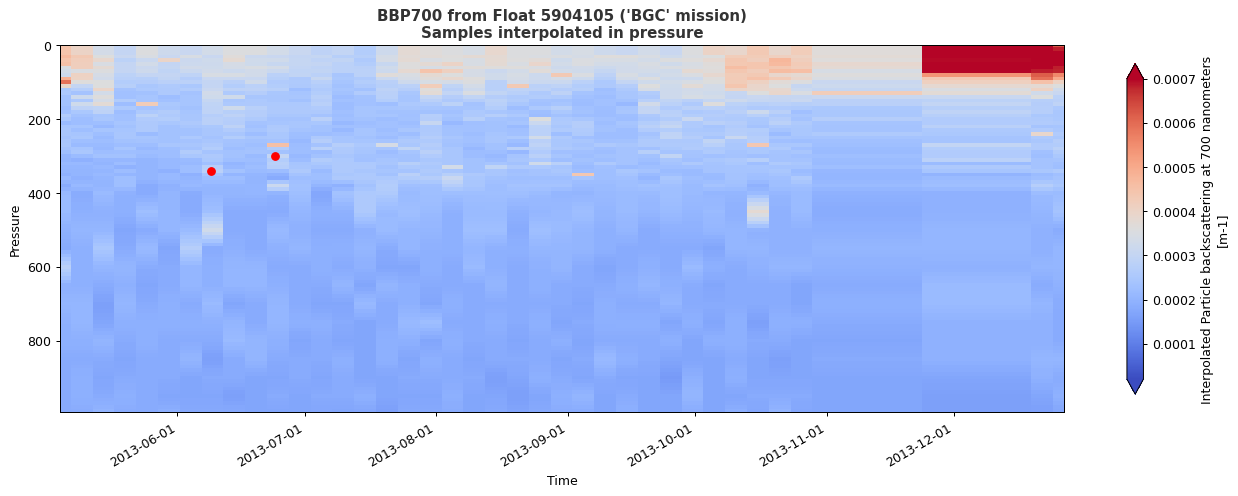

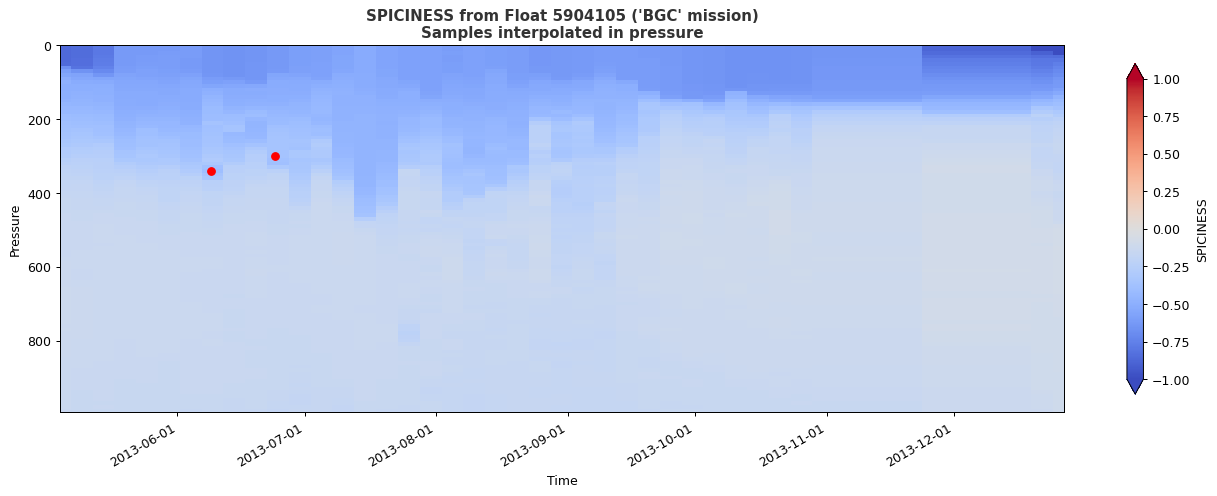

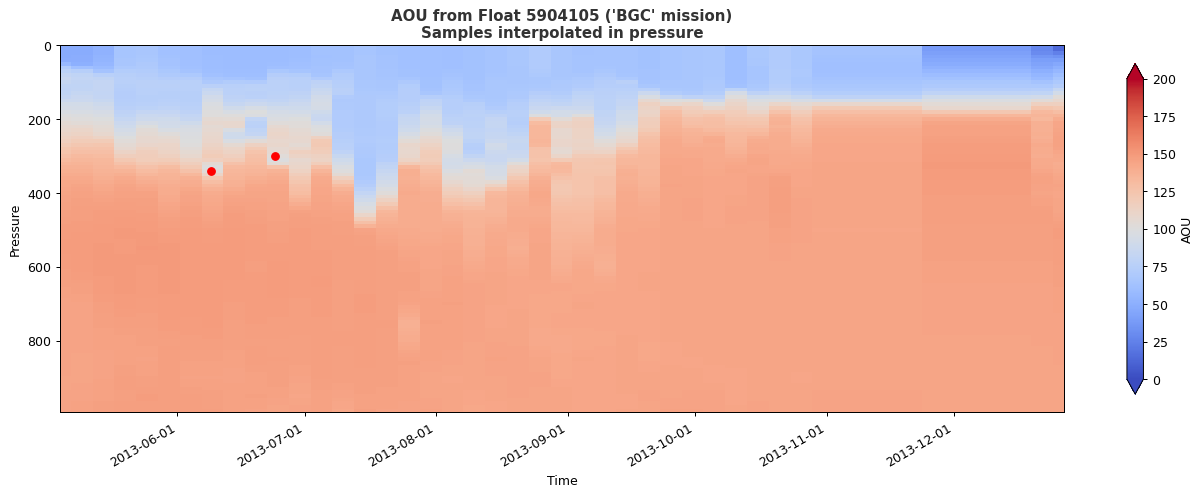

In [89]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Choose a high-contrast colormap
cmap = plt.get_cmap('coolwarm')  # Try 'inferno', 'cividis', or 'coolwarm' for higher contrast


c_bounds = {
    'BBP700': (2e-5, 70e-5),
    'CDOM': (0, 2.5),
    'CHLA': (0, 0.2),
    'DOWNWELLING_PAR': (0, 600),
    'DOWN_IRRADIANCE380': (0, 1),
    'DOWN_IRRADIANCE412': (0, 1),
    'DOWN_IRRADIANCE490': (0, 1),
    'DOXY': (50, 400),
    'SPICINESS': (-1, 1),
    'AOU':(0,200)
}


for param in bgc_params:
    vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)
    
    fig, ax = scatter_plot(subset_dsi, param, this_y='PRES_INTERPOLATED', vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(f"{param} from Float {WMO} ('{f.mission}' mission)\nSamples interpolated in pressure", 
                 fontdict={'weight': 'bold', 'size': 12, 'alpha': 0.8})

    # Add markers for subduction events
    for event in subduction_events:
        event_time = pd.to_datetime(event['date'])
        ax.plot(event_time, event['pressure'], 'ro')  # 'ro' creates a red circle marker

    # Additional plot customizations
    ax.set_xlabel("Time")
    ax.set_ylabel("Pressure")
    
    # Customize the time axis if needed
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()

plt.show()


## Between 2013-07-14 and 2013-07-24 there seems to be an important event  

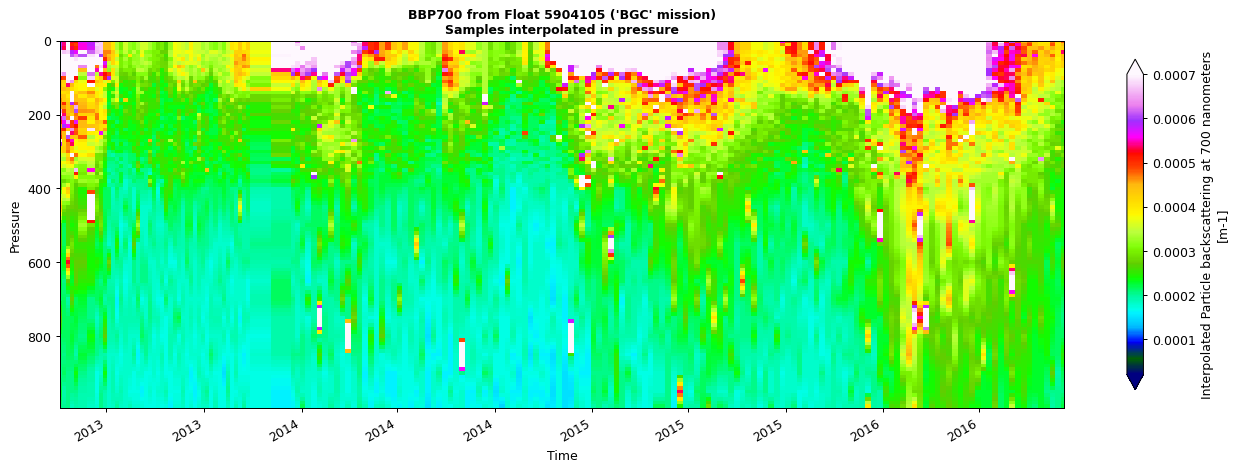

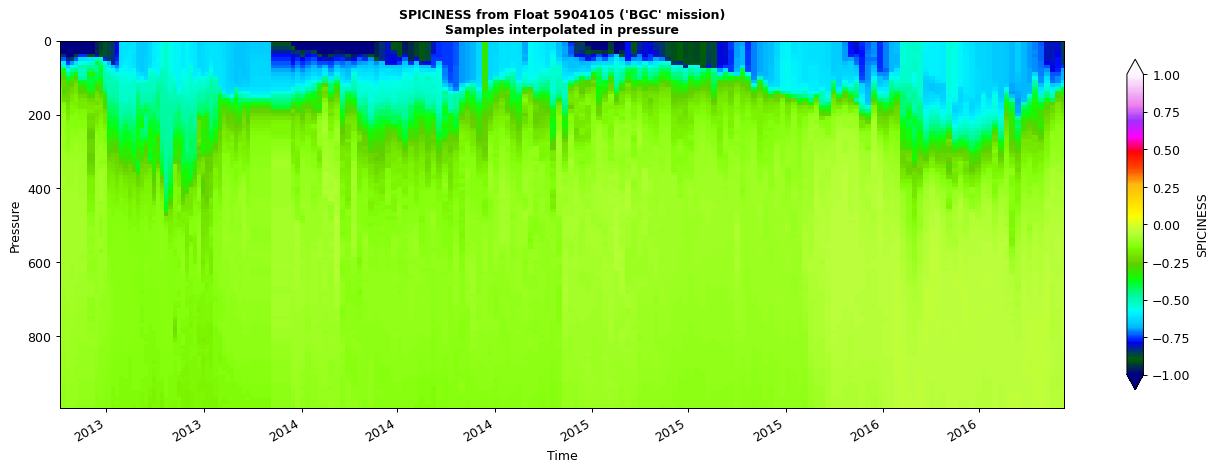

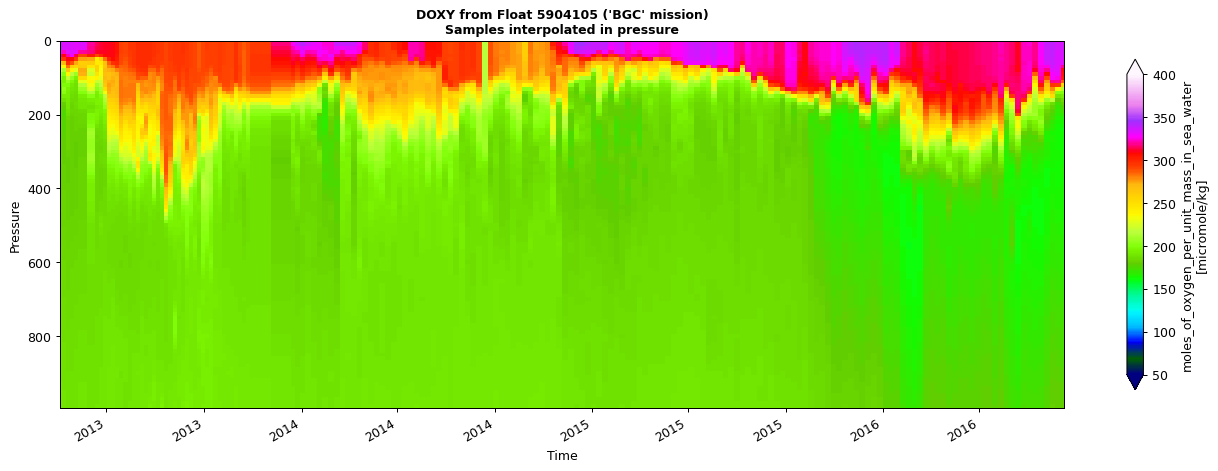

In [62]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot all variables
for param in bgc_params:
    vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)
    
    fig, ax = scatter_plot(dsi, param, this_y='PRES_INTERPOLATED', vmin=vmin, vmax=vmax)
    ax.set_title(f"{param} from Float {WMO} ('{f.mission}' mission)\nSamples interpolated in pressure", 
                 fontdict={'weight': 'bold', 'size': 10})

    # Automatically set date ticks with proper formatting
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.AutoDateLocator()))

    # Rotate date labels for readability
    fig.autofmt_xdate()

    # Additional plot customizations
    ax.set_xlabel("Time")
    ax.set_ylabel("Pressure")

plt.show()


## Reproduce figure from Llort Float

In [1]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # Functions to easily make maps and plots

# Make a fresh start
import argopy
argopy.set_options(cachedir='cache_bgc')
argopy.reset_options()
argopy.clear_cache()

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import gsw
import pandas as pd
xr.set_options(display_expand_attrs = False)

In [5]:
WMO = 5904105

In [6]:
# Dl data and compute SPIC and AOU
f = DataFetcher(ds='bgc', mode='expert', params='all').profile(WMO, np.arange(0, 200)).load()
ds = f.data
ds = calculate_AOU_for_all_profiles(ds)
ds = calculate_spiciness_for_all_profiles(ds)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Get the list of BGC parameters:
bgc_params = ['BBP700','SPICINESS','AOU']


# Define readable color bounds for each BGC variable
c_bounds = {
    'BBP700': (2e-5, 70e-5),
    'CDOM': (0, 2.5),
    'CHLA': (0, 0.2),
    'DOWNWELLING_PAR': (0, 600),
    'DOWN_IRRADIANCE380': (0, 1),
    'DOWN_IRRADIANCE412': (0, 1),
    'DOWN_IRRADIANCE490': (0, 1),
    'DOXY': (50, 400),
    'SPICINESS': (-1, 1),
    'AOU':(0,200)
}

dsp = ds.argo.point2profile()
# std_lev = np.arange(0, np.round(ds['PRES'].max())-200, 25.0)
std_lev = np.arange(0., 1000., 10.0)
dsi = dsp.argo.interp_std_levels(std_lev)
dsi

subset_dsi = dsi.where((dsi.TIME >= np.datetime64("2016-09-01")) & (dsi.TIME < np.datetime64("2016-11-30")), drop=True)


# Plot all variables
for param in bgc_params:
    vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)
    
    fig, ax = scatter_plot(subset_dsi, param, this_y='PRES_INTERPOLATED', vmin=vmin, vmax=vmax)
    ax.set_title(f"{param} from Float {WMO} ('{f.mission}' mission)\nSamples interpolated in pressure", 
                 fontdict={'weight': 'bold', 'size': 0.2, 'alpha': 0.2})

    # Set x-axis to show daily ticks
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Set interval to 5 days, adjust as needed
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format to show year-month-day

    # Rotate date labels for better readability
    fig.autofmt_xdate()

    # Add markers for subduction events
    for event in subduction_events:
        event_time = pd.to_datetime(event['date'])
        ax.plot(event_time, event['pressure'], 'ro')  # 'ro' creates a red circle marker

    # Additional plot customizations
    ax.set_xlabel("Time")
    ax.set_ylabel("Pressure")

plt.show()


ValueError: For X (101) and Y (0) with flat shading, A should have shape (-1, 100, 3) or (-1, 100, 4) or (-1, 100) or (-100,), not (0,)